Evaluation of how much the three features affect the conversion rate

In [3]:
import pandas as pd

df = pd.read_csv('/content/balanced_data.csv')

# Set 'full_name' as the index
df.set_index('full_name', inplace=True)

features = [
    "engagement_rate",
    "follower_count_c",
    "posting_frequency_c",
]

label = ["_converted"]

# Define your desired columns (features + label)
desired_columns = features + label

# Keep only the desired columns
df = df[desired_columns]

# Now `df` has 'full_name' as index and only the relevant features + label
print(df.head())
print(df.shape)


                     engagement_rate  follower_count_c  posting_frequency_c  \
full_name                                                                     
Sejer Dalum                     4.16            3459.0                 0.60   
René Holten Poulsen             0.77           36176.0                 0.26   
Regina ?                       12.11           30000.0                  NaN   
Nyla Whelan                     0.80            6759.0                 0.84   
Adam Gould                      0.02           11423.0                 0.73   

                     _converted  
full_name                        
Sejer Dalum               False  
René Holten Poulsen       False  
Regina ?                  False  
Nyla Whelan               False  
Adam Gould                False  
(196, 4)


Method 1: Logistic Coef

For interpretable model, it's fast and intuitive but assumes linearity.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df[features]
y = df['_converted']

# Split data before imputation and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
'''
# Fit logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

'''
# Build preprocessing + model pipeline
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),       # Handle NaNs
    ('scaler', StandardScaler()),                      # Standardize
    ('clf', LogisticRegression(max_iter=1000))         # Logistic Regression
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get model coefficients
model = pipeline.named_steps['clf']
scaler = pipeline.named_steps['scaler']
imputer = pipeline.named_steps['imputer']

# Print coefficients with feature names
for feat, coef in zip(features, model.coef_[0]):
    print(f"{feat}: {coef:.4f}")


engagement_rate: 0.1760
follower_count_c: 0.2177
posting_frequency_c: -0.0018


In [5]:
from sklearn.ensemble import HistGradientBoostingClassifier

X = df[features]
y = df['_converted']

model = HistGradientBoostingClassifier()
model.fit(X, y)

HistGradientBoostingClassifier()

Method 2: Permutation Importance

For any model, and pro: model-agnostic, but it can be slow

In [6]:
from sklearn.inspection import permutation_importance

# Make sure you use validation/test set
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

# Display importances
for i in result.importances_mean.argsort()[::-1]:
    print(f"{features[i]}: {result.importances_mean[i]:.4f}")


follower_count_c: 0.2612
engagement_rate: 0.2279
posting_frequency_c: 0.1116


Method 3: SHAP Values

Tree-based or complex models, pro: local+global interpretation, but can be slower and more setup

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:24:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


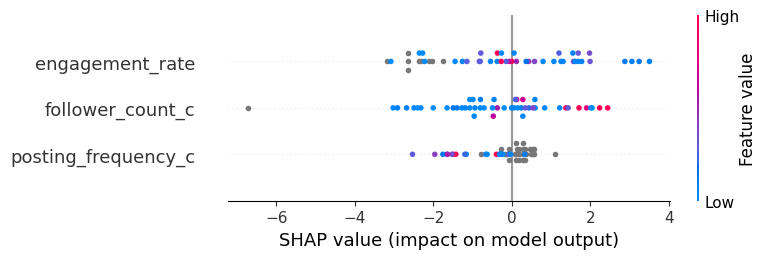

In [7]:
import shap
import xgboost as xgb

# Fit a tree-based model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot (if using notebook)
shap.summary_plot(shap_values, X_test, feature_names=features)


In [8]:
import numpy as np

# Calculate mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Show feature importances
for feat, val in sorted(zip(features, mean_abs_shap), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {val:.4f}")


engagement_rate: 1.5036
follower_count_c: 1.2611
posting_frequency_c: 0.5917


Method 4: Correlation with Label

Quick overview and easy to use, but too simplisitic

In [9]:
correlations = df[features + label].corr()
print(correlations['_converted'].drop('_converted'))


engagement_rate        0.043240
follower_count_c       0.071584
posting_frequency_c    0.009616
Name: _converted, dtype: float64


Apply a new Some value and derive the correlation to conversion rate

In [10]:
df.head()

,engagement_rate,follower_count_c,posting_frequency_c,_converted
full_name,,,,
Sejer Dalum,4.16,3459.0,0.60,False
René Holten Poulsen,0.77,36176.0,0.26,False
Regina ?,12.11,30000.0,NaN,False
Nyla Whelan,0.80,6759.0,0.84,False
Adam Gould,0.02,11423.0,0.73,False


In [135]:
import pandas as pd
import numpy as np

# Scoring references (benchmark)
scoring_reference = {
    'pf': 1.2544,
    'er': 9.0481,
    'fc': (961, 467930),
}

# Scoring parameters (weights)
scoring_params = {
    'pf': 1.76,
    'er': 4.48,
    'fc': 3.76,
}

# Scoring logic for follower count (custom 2-threshold logic)
def compute_fc_score(value, low_ref, high_ref, weight):
    if pd.isna(value):
        return 0
    elif value <= low_ref:
        return 0  # Very unlikely to convert
    elif value >= high_ref:
        return weight  # Very likely to convert
    else:
        # Linearly interpolate score between low and high
        return ((value - low_ref) / (high_ref - low_ref)) * weight

# Define scoring logic
def compute_score(value, reference, weight):
    if pd.isna(value):
        return 0  # or np.nan if you prefer
    return weight if value >= reference else (value / reference) * weight

# Apply scoring
df['pf_score'] = df['posting_frequency_c'].apply(lambda x: compute_score(x, scoring_reference['pf'], scoring_params['pf']))
df['er_score'] = df['engagement_rate'].apply(lambda x: compute_score(x, scoring_reference['er'], scoring_params['er']))
df['fc_score'] = df['follower_count_c'].apply(lambda x: compute_fc_score(x, scoring_reference['fc'][0], scoring_reference['fc'][1], scoring_params['fc']))

# Calculate total score
df['total_score'] = df['pf_score'] + df['er_score'] + df['fc_score']

# Optional: define launch category (same as SQL logic)
def assign_category(row):
    if row['pf_score'] >= 1. and row['er_score'] >= 1. and row['fc_score'] >= 1. and row['total_score'] >= 6:
        return 'launch'
    elif row['fc_score'] >= 0.5 and row['total_score'] >= 5:
        return 'review'
    else:
        return 'ignore'

df['launch_category'] = df.apply(assign_category, axis=1)

# Show result
print(df)


     level_0  index            full_name  engagement_rate  follower_count_c  \
0          0      0          Sejer Dalum             4.16            3459.0   
1          1      1  René Holten Poulsen             0.77           36176.0   
2          2      2             Regina ?            12.11           30000.0   
3          3      3          Nyla Whelan             0.80            6759.0   
4          4      4           Adam Gould             0.02           11423.0   
..       ...    ...                  ...              ...               ...   
191      191    191        Nafeesa Afsar             0.00            2154.0   
192      192    192  Mr. blayne Abrahams             1.71            6231.0   
193      193    193       Caroline Quinn             3.51           42009.0   
194      194    194         Simon Church             0.00           10528.0   
195      195    195   Ms. Justine Holmes             0.00           61647.0   

     posting_frequency_c  _converted  pf_score  er_

In [139]:
import pandas as pd
import numpy as np

# Scoring references (benchmarks)
scoring_reference = {
    'pf': 1,
    'er': 4,
    'fc': 75000,
}

# Scoring parameters (weights)
scoring_params = {
    'pf': 3.6,
    'er': 3.3,
    'fc': 3.1,
    'min_launch': 1.2,
    'min_review': 0.42,
}

# Define generic scoring function
def compute_score(value, reference, weight):
    if pd.isna(value):
        return 0
    return weight if value >= reference else (value / reference) * weight

# Apply scoring to each column
df['pf_score'] = df['posting_frequency_c'].apply(lambda x: compute_score(x, scoring_reference['pf'], scoring_params['pf']))
df['er_score'] = df['engagement_rate'].apply(lambda x: compute_score(x, scoring_reference['er'], scoring_params['er']))
df['fc_score'] = df['follower_count_c'].apply(lambda x: compute_score(x, scoring_reference['fc'], scoring_params['fc']))

# Calculate total score
df['total_score'] = df['pf_score'] + df['er_score'] + df['fc_score']

# Launch category logic
def assign_category(row):
    if row['pf_score'] >= scoring_params['min_launch'] and \
       row['er_score'] >= scoring_params['min_launch'] and \
       row['fc_score'] >= scoring_params['min_launch'] and \
       row['total_score'] >= 6:
        return 'launch'
    elif row['fc_score'] >= scoring_params['min_review'] and row['total_score'] >= 5:
        return 'review'
    else:
        return 'ignore'

df['launch_category'] = df.apply(assign_category, axis=1)

# Show relevant columns
print(df[['posting_frequency_c', 'engagement_rate', 'follower_count_c',
          'pf_score', 'er_score', 'fc_score', 'total_score', 'launch_category']])


     posting_frequency_c  engagement_rate  follower_count_c  pf_score  \
0                   0.60             4.16            3459.0     2.160   
1                   0.26             0.77           36176.0     0.936   
2                    NaN            12.11           30000.0     0.000   
3                   0.84             0.80            6759.0     3.024   
4                   0.73             0.02           11423.0     2.628   
..                   ...              ...               ...       ...   
191                  NaN             0.00            2154.0     0.000   
192                 0.40             1.71            6231.0     1.440   
193                  NaN             3.51           42009.0     0.000   
194                  NaN             0.00           10528.0     0.000   
195                  NaN             0.00           61647.0     0.000   

     er_score  fc_score  total_score launch_category  
0     3.30000  0.142972     5.602972          ignore  
1     0.63525

In [140]:
import pandas as pd

# Assuming df contains 'launch_category' and '_converted' columns
conversion_by_category = df.groupby('launch_category')['_converted'].agg(
    conversion_rate='mean',
    total_leads='count',
    converted_leads='sum'
).reset_index()

print(conversion_by_category)


  launch_category  conversion_rate  total_leads  converted_leads
0          ignore         0.513699          146               75
1          launch         0.545455           11                6
2          review         0.548387           31               17


Statistics

In [13]:
# Group by _converted and describe each feature
grouped_stats = df.groupby(label)[features].describe()

In [14]:
grouped_stats.engagement_rate

,count,mean,std,min,25%,50%,75%,max
_converted,,,,,,,,
False,62.0,3.586774,6.001179,0.0,0.3525,0.875,4.125,33.18
True,84.0,4.093452,5.695025,0.0,0.6350,1.775,5.225,34.31


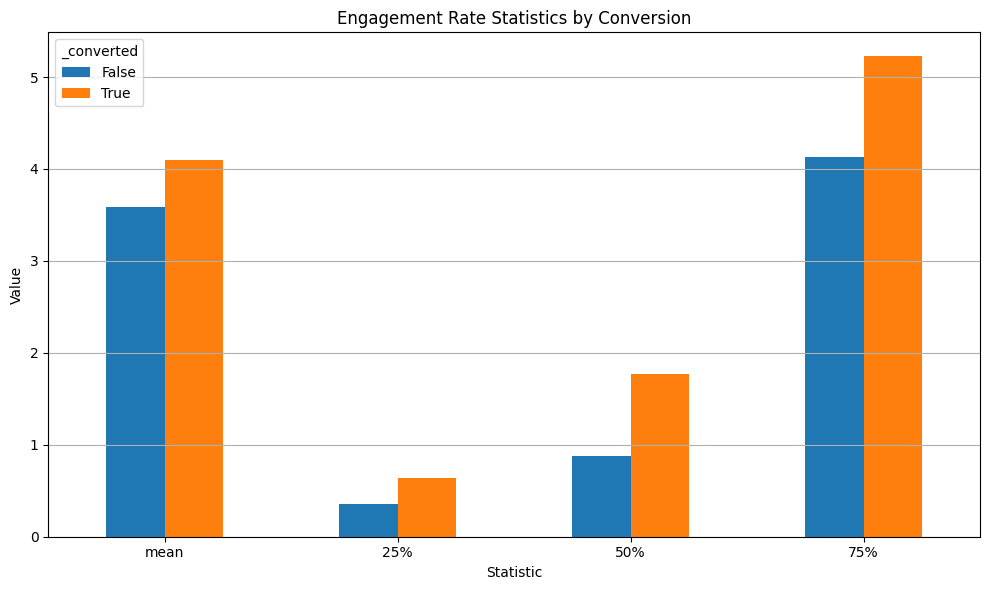

In [15]:
import matplotlib.pyplot as plt

# Pick the statistics to include in the plot
stats_to_plot = ["mean", "25%", "50%", "75%"]

# Transpose and slice the desired stats
data_to_plot = grouped_stats.engagement_rate[stats_to_plot].transpose()

# Plot
data_to_plot.plot(kind="bar", figsize=(10, 6))
plt.title("Engagement Rate Statistics by Conversion")
plt.ylabel("Value")
plt.xlabel("Statistic")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


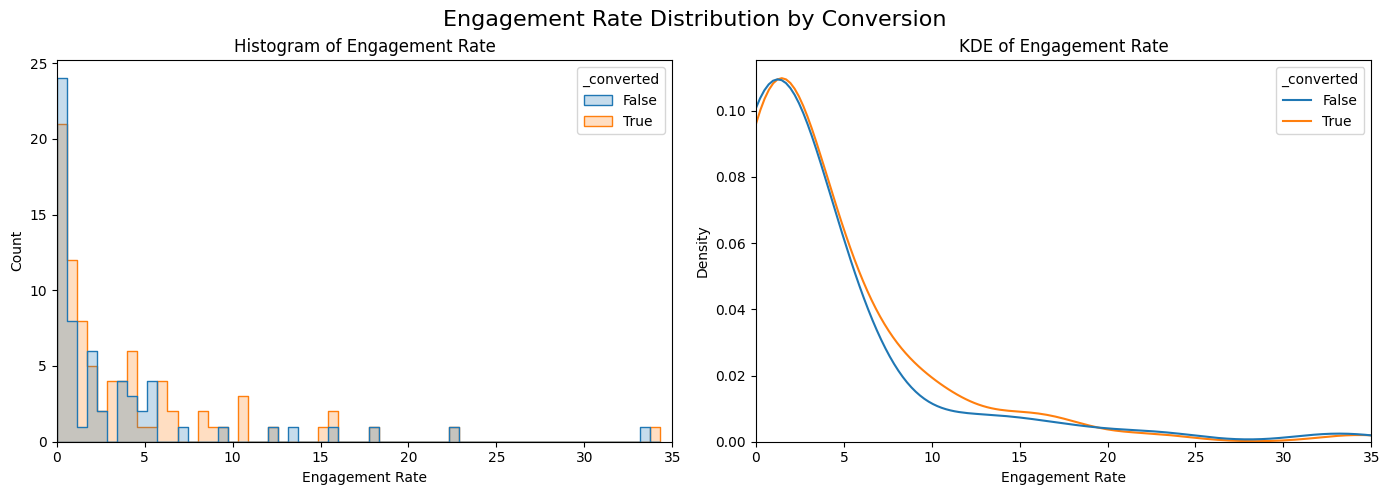

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Clean data
df = df.loc[:, ~df.columns.duplicated()]
df_clean = df[["_converted", "engagement_rate"]].dropna()
df_clean["_converted"] = df_clean["_converted"].astype(str)

# Define color palette
palette = {"False": "#1f77b4", "True": "#ff7f0e"}

# Create subplot layout WITHOUT shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Plot 1: Histogram (left)
sns.histplot(
    data=df_clean,
    x="engagement_rate",
    hue="_converted",
    bins=60,
    kde=False,
    palette=palette,
    element="step",
    stat="count",
    ax=axes[0]
)
axes[0].set_title("Histogram of Engagement Rate")
axes[0].set_xlabel("Engagement Rate")
axes[0].set_ylabel("Count")
axes[0].set_xlim(0, 35)

# Plot 2: KDE (right)
sns.kdeplot(
    data=df_clean,
    x="engagement_rate",
    hue="_converted",
    common_norm=False,
    fill=False,
    palette=palette,
    bw_adjust=1.0,
    ax=axes[1],
)
axes[1].set_title("KDE of Engagement Rate")
axes[1].set_xlabel("Engagement Rate")
axes[1].set_ylabel("Density")
axes[1].set_xlim(0, 35)

# Adjust layout
plt.suptitle("Engagement Rate Distribution by Conversion", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Space for title
plt.show()


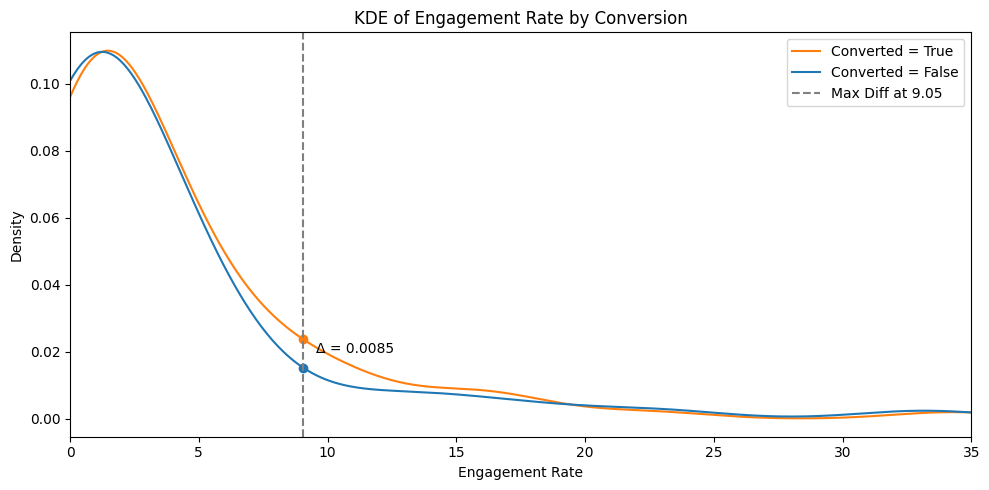

Maximum vertical difference of 0.0085 occurs at engagement_rate = 9.0481


In [17]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Clean and split the data
df_clean = df[["_converted", "engagement_rate"]].dropna()
df_clean["_converted"] = df_clean["_converted"].astype(str)

x_true = df_clean[df_clean["_converted"] == "True"]["engagement_rate"]
x_false = df_clean[df_clean["_converted"] == "False"]["engagement_rate"]

# Define common x-axis grid
x_grid = np.linspace(0, 35, 500)

# Compute KDEs
kde_true = gaussian_kde(x_true, bw_method='scott')
kde_false = gaussian_kde(x_false, bw_method='scott')

y_true = kde_true(x_grid)
y_false = kde_false(x_grid)

# Compute absolute difference
diff = np.abs(y_true - y_false)
max_idx = np.argmax(diff)
max_x = x_grid[max_idx]
max_y_true = y_true[max_idx]
max_y_false = y_false[max_idx]
max_diff = diff[max_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_grid, y_true, label="Converted = True", color="#ff7f0e")
plt.plot(x_grid, y_false, label="Converted = False", color="#1f77b4")
plt.axvline(max_x, color='gray', linestyle='--', label=f"Max Diff at {max_x:.2f}")
plt.scatter([max_x], [max_y_true], color="#ff7f0e")
plt.scatter([max_x], [max_y_false], color="#1f77b4")
plt.text(max_x + 0.5, (max_y_true + max_y_false) / 2, f"Δ = {max_diff:.4f}", color='black')

plt.title("KDE of Engagement Rate by Conversion")
plt.xlabel("Engagement Rate")
plt.ylabel("Density")
plt.xlim(0, 35)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Maximum vertical difference of {max_diff:.4f} occurs at engagement_rate = {max_x:.4f}")


In [18]:
grouped_stats.posting_frequency_c

,count,mean,std,min,25%,50%,75%,max
_converted,,,,,,,,
False,37.0,0.583784,0.506641,0.01,0.24,0.47,0.73,2.33
True,41.0,0.595122,0.667020,0.01,0.21,0.40,0.74,3.41


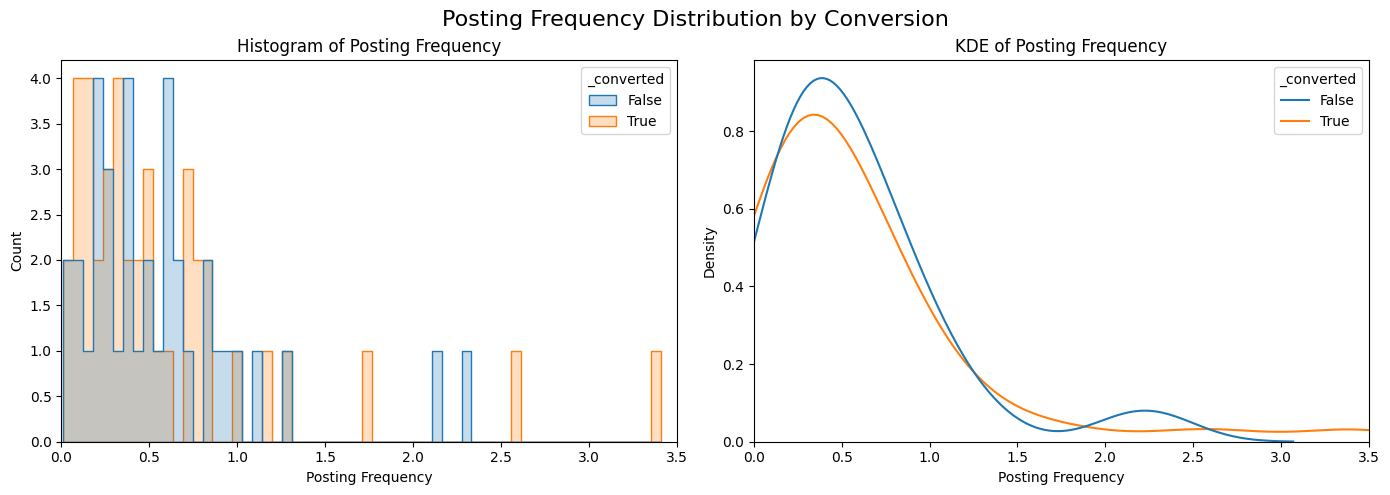

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Clean data
df = df.loc[:, ~df.columns.duplicated()]
df_clean = df[["_converted", "posting_frequency_c"]].dropna()
df_clean["_converted"] = df_clean["_converted"].astype(str)

# Define color palette
palette = {"False": "#1f77b4", "True": "#ff7f0e"}

# Create subplot layout WITHOUT shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Plot 1: Histogram (left)
sns.histplot(
    data=df_clean,
    x="posting_frequency_c",
    hue="_converted",
    bins=60,
    kde=False,
    palette=palette,
    element="step",
    stat="count",
    ax=axes[0]
)
axes[0].set_title("Histogram of Posting Frequency")
axes[0].set_xlabel("Posting Frequency")
axes[0].set_ylabel("Count")
axes[0].set_xlim(0, 3.5)  # Based on your posted stats

# Plot 2: KDE (right)
sns.kdeplot(
    data=df_clean,
    x="posting_frequency_c",
    hue="_converted",
    common_norm=False,
    fill=False,
    palette=palette,
    bw_adjust=1.0,
    ax=axes[1],
)
axes[1].set_title("KDE of Posting Frequency")
axes[1].set_xlabel("Posting Frequency")
axes[1].set_ylabel("Density")
axes[1].set_xlim(0, 3.5)

# Adjust layout
plt.suptitle("Posting Frequency Distribution by Conversion", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


📍 KDE curves intersect at posting_frequency_c values:
 - 0.1349
 - 1.2544
 - 1.8831
 - 2.5875


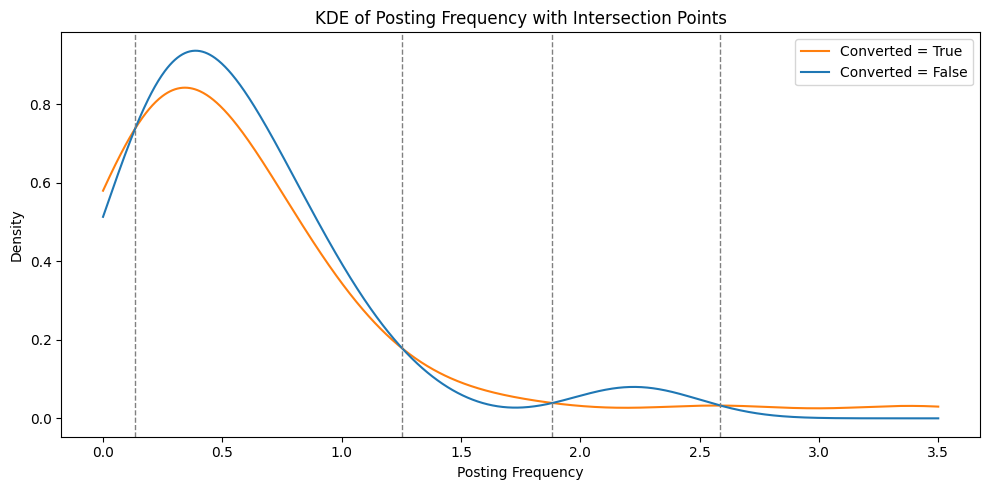

In [20]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Clean and prepare the data
df_clean = df[["_converted", "posting_frequency_c"]].dropna()
df_clean["_converted"] = df_clean["_converted"].astype(str)

# Split the data
x_true = df_clean[df_clean["_converted"] == "True"]["posting_frequency_c"]
x_false = df_clean[df_clean["_converted"] == "False"]["posting_frequency_c"]

# Define x grid
x_grid = np.linspace(0, 3.5, 1000)

# Compute KDEs
kde_true = gaussian_kde(x_true, bw_method='scott')
kde_false = gaussian_kde(x_false, bw_method='scott')

y_true = kde_true(x_grid)
y_false = kde_false(x_grid)

# Difference
diff = y_true - y_false

# Find zero-crossings (sign changes)
sign_changes = np.where(np.diff(np.sign(diff)))[0]

# Interpolate crossing points
intersections = []
for idx in sign_changes:
    x0, x1 = x_grid[idx], x_grid[idx+1]
    y0, y1 = diff[idx], diff[idx+1]
    x_cross = x0 - y0 * (x1 - x0) / (y1 - y0)  # Linear interpolation
    intersections.append(x_cross)

# Print result
print("📍 KDE curves intersect at posting_frequency_c values:")
for x in intersections:
    print(f" - {x:.4f}")

# Plot with intersections
plt.figure(figsize=(10, 5))
plt.plot(x_grid, y_true, label="Converted = True", color="#ff7f0e")
plt.plot(x_grid, y_false, label="Converted = False", color="#1f77b4")
for x in intersections:
    plt.axvline(x, color="gray", linestyle="--", linewidth=1)
plt.title("KDE of Posting Frequency with Intersection Points")
plt.xlabel("Posting Frequency")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
grouped_stats.follower_count_c

,count,mean,std,min,25%,50%,75%,max
_converted,,,,,,,,
False,91.0,93261.109890,201408.290116,0.0,3389.50,17359.0,63317.0,1200000.0
True,98.0,135285.663265,359383.143810,201.0,3343.75,17796.0,104438.0,3000000.0


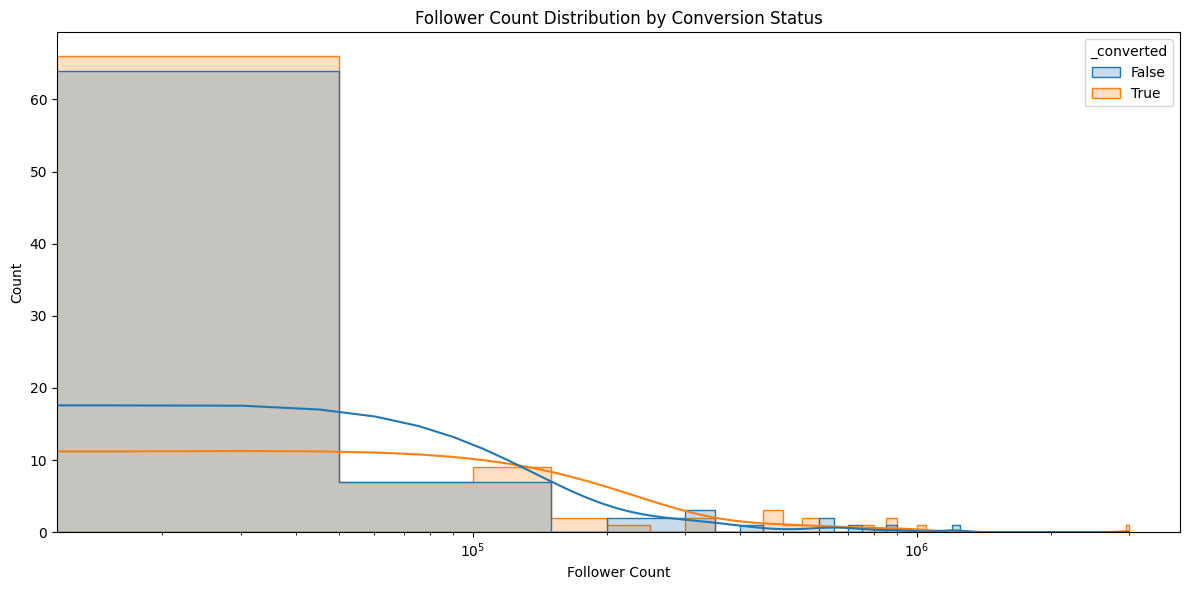

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x='follower_count_c',
    hue='_converted',
    kde=True,
    bins=60,
    palette={'False': '#1f77b4', 'True': '#ff7f0e'},
    element='step',
    stat='count'
)
plt.title('Follower Count Distribution by Conversion Status')
plt.xlabel('Follower Count')
plt.ylabel('Count')
plt.xscale('log')  # Use log scale if range is large
plt.tight_layout()
plt.show()


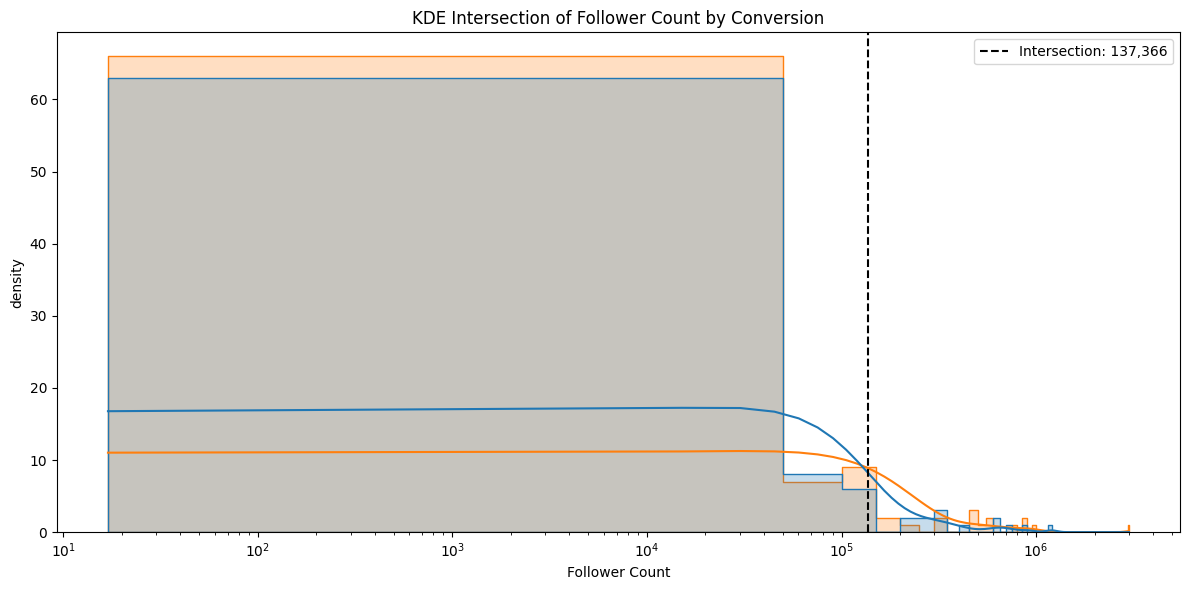

🔍 Counter point (intersection of KDEs): 137,366


In [42]:
# Drop NaNs and non-positive follower counts
df = df[df['follower_count_c'].notna()]
df = df[df['follower_count_c'] > 0]

# Extract values
true_vals = df[df['_converted'] == 'True']['follower_count_c'].dropna()
false_vals = df[df['_converted'] == 'False']['follower_count_c'].dropna()

# Define common x-range (log-spaced due to skewed distribution)
x_vals = np.logspace(np.log10(df['follower_count_c'].min()), np.log10(df['follower_count_c'].max()), 1000)

# KDE estimation
kde_true = gaussian_kde(true_vals)
kde_false = gaussian_kde(false_vals)

y_true = kde_true(x_vals)
y_false = kde_false(x_vals)

# Find intersection point (where difference changes sign)
diff = y_true - y_false
sign_change_idx = np.where(np.diff(np.sign(diff)))[0]

# Get the x-value where curves intersect (first crossing)
if len(sign_change_idx) > 0:
    intersect_idx = sign_change_idx[0]
    intersection_point = x_vals[intersect_idx]
else:
    intersection_point = None

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='follower_count_c', hue='_converted', kde=True, bins=60, element='step', stat='count', palette={'False': '#1f77b4', 'True': '#ff7f0e'})
plt.xscale('log')
if intersection_point:
    plt.axvline(intersection_point, color='black', linestyle='--', label=f'Intersection: {int(intersection_point):,}')
    plt.legend()
plt.title('KDE Intersection of Follower Count by Conversion')
plt.xlabel('Follower Count')
plt.ylabel('density')
plt.tight_layout()
plt.show()

# Print result
print(f'🔍 Counter point (intersection of KDEs): {int(intersection_point):,}' if intersection_point else "No intersection found.")

In [48]:
# Convert 'True'/'False' string to boolean
df['_converted'] = df['_converted'].astype(str)  # Just in case it's not string
df['_converted'] = df['_converted'].map({'True': 1, 'False': 0})

# Drop NaNs or unexpected values
df = df[df['_converted'].isin([0, 1])]


In [49]:
from sklearn.metrics import roc_curve

y_true = df['_converted']
X = df['follower_count_c']

fpr, tpr, thresholds = roc_curve(y_true, X)
j_scores = tpr - fpr
best_threshold = thresholds[np.argmax(j_scores)]

print(f"📍 Best threshold by Youden's J: {int(best_threshold):,}")


📍 Best threshold by Youden's J: 5,383


In [50]:
from sklearn.tree import DecisionTreeClassifier

X = df[['follower_count_c']]
y = df['_converted'].astype(bool)

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X, y)

threshold = tree.tree_.threshold[0]
print(f"📍 Best threshold from decision tree: {int(threshold):,}")


📍 Best threshold from decision tree: 140


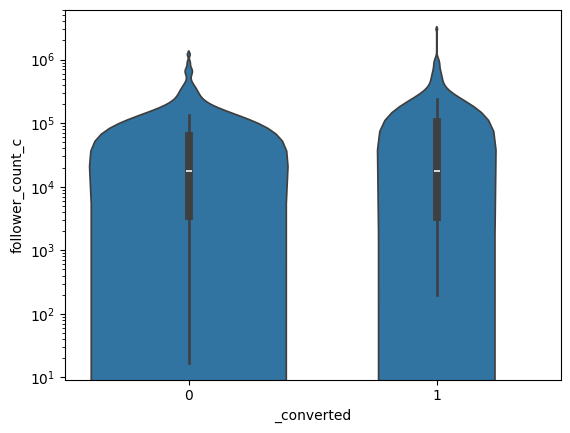

In [51]:
sns.violinplot(data=df, x='_converted', y='follower_count_c')
plt.yscale('log')
plt.show()


In [134]:
# Calculate global percentiles on entire dataset
#p_low = df['follower_count_c'].quantile(0.33)
p_low = 961
#p_high = df['follower_count_c'].quantile(0.)
p_high = 467930

print(f"low percentile: {int(p_low):,}")
print(f"high percentile: {int(p_high):,}")

# Define segment function based on these values
def segment_follower_count(x):
    if x < p_low:
        return 'Low'
    elif x < p_high:
        return 'Medium'
    else:
        return 'High'

# Apply segmentation
df['follower_segment'] = df['follower_count_c'].apply(segment_follower_count)

# Analyze conversion rate by segment
conversion_by_segment = df.groupby('follower_segment')['_converted'].agg(['count', 'sum', 'mean'])
conversion_by_segment.rename(columns={'sum': 'converted', 'mean': 'conversion_rate'}, inplace=True)

print(conversion_by_segment)


low percentile: 961
high percentile: 467,930
                  count  converted  conversion_rate
follower_segment                                   
High                 15         10         0.666667
Low                  10          3         0.300000
Medium              163         85         0.521472


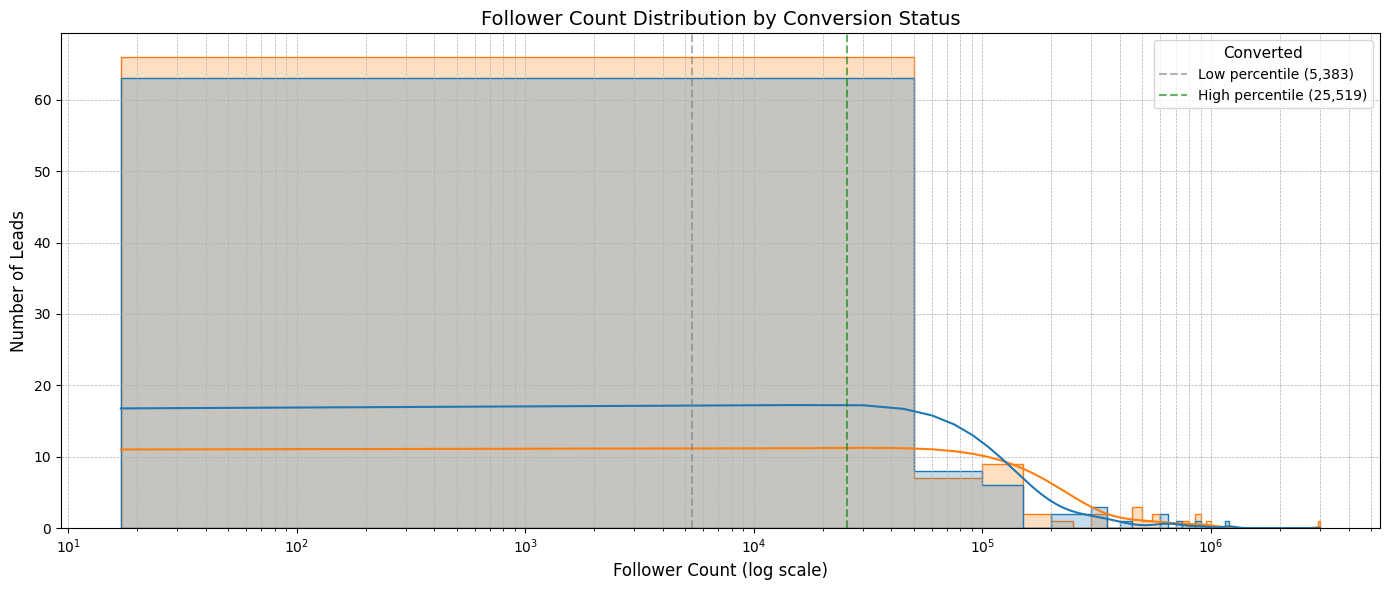

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(14, 6))
sns.histplot(
    data=df,
    x='follower_count_c',
    hue='_converted',
    kde=True,
    bins=60,
    palette = {0: '#1f77b4', 1: '#ff7f0e'},
    element='step',
    stat='count',
    common_norm=False  # avoid normalizing across classes
)

# Add vertical lines for key percentiles (optional)
plt.axvline(p_low, color='gray', linestyle='--', alpha=0.6, label=f'Low percentile ({int(p_low):,})')
plt.axvline(p_high, color='green', linestyle='--', alpha=0.6, label=f'High percentile ({int(p_high):,})')

# Customize axes
plt.xscale('log')
plt.xlabel('Follower Count (log scale)', fontsize=12)
plt.ylabel('Number of Leads', fontsize=12)
plt.title('Follower Count Distribution by Conversion Status', fontsize=14)
plt.legend(title='Converted', title_fontsize=11)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [127]:
import numpy as np

# Sort unique follower counts
cut_points = np.percentile(df['follower_count_c'], np.arange(5, 100, 1))  # Try 5% to 95% by 1%

results = []

for cut in cut_points:
    low = df[df['follower_count_c'] <= cut]
    high = df[df['follower_count_c'] > cut]

    if len(low) == 0 or len(high) == 0:
        continue

    conv_low = low['_converted'].mean()
    conv_high = high['_converted'].mean()
    diff = abs(conv_high - conv_low)

    results.append((cut, diff, conv_low, conv_high))

# Sort by highest separation
results.sort(key=lambda x: x[1], reverse=True)

# Show top 5
for i, (cut, diff, conv_low, conv_high) in enumerate(results[:5], 1):
    print(f"{i}. Threshold: {int(cut):,}, Diff: {diff:.2f}, Low CR: {conv_low:.2f}, High CR: {conv_high:.2f}")


1. Threshold: 961, Diff: 0.23, Low CR: 0.30, High CR: 0.53
2. Threshold: 1,148, Diff: 0.18, Low CR: 0.36, High CR: 0.53
3. Threshold: 467,930, Diff: 0.16, Low CR: 0.51, High CR: 0.67
4. Threshold: 809,430, Diff: 0.15, Low CR: 0.52, High CR: 0.67
5. Threshold: 360,889, Diff: 0.14, Low CR: 0.51, High CR: 0.65
